In [1]:
from gbm.finder import BurstCatalog
from gbm.finder import TriggerFtp
import os
    
import gbm
from gbm import test_data_dir
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from gbm.plot import Lightcurve, Spectrum


burstcat = BurstCatalog()


# burstcat.num_rows


/Users/tahumada/Research/GBM/gbm_data_tools-1.1.1/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


Finished in 76 s


In [ ]:
bursts = burstcat.get_table(columns=('name',
                                     'trigger_name', 
                                     't90',
                                     't90_start',
                                    ))

erange_nai = (8.0, 900.0) # in keV
erange_bgo = (325, 35000.0)
    
failed = []

# for i in range(len(bursts.trigger_name)):
for i in range(1000):
# for i in [0,1,2]:

    print(i,len(bursts.trigger_name),bursts.trigger_name[i])
    
    try:
        # initialize the Trigger data finder with a trigger number
        burst = bursts.trigger_name[i]
        trig_finder = TriggerFtp(burst[2:])

        #check if exists 
        path_tte = './Bursts/'+bursts.trigger_name[i]

        if not os.path.isdir(path_tte) or len(path_tte)<14 or not os.path.isfile(path_tte+'/done.txt'):
            trig_finder.get_tte(path_tte,verbose = False)

        else:
            print('TTE Downloaded')
            continue

        files_tte = glob.glob(path_tte+'/*tte*')

        temp_time = []
        temp_flux = []
        temp_idx = []
        temp_bg = []
        temp_spec = []
        temp_ebin = []
        temp_det = []

        for ii in range(len(files_tte)):
        # open a TTE file
            tte = TTE.open(files_tte[ii])
            # bin to 1.024 s resolution, reference time is trigger time
            phaii = tte.to_phaii(bin_by_time, 1.024*2, time_ref=0.0)

            # maybe change the energy range??

            erange = erange_nai
            if 'tte_b' in files_tte[ii]:
                erange = erange_bgo

            lc_data = phaii.to_lightcurve(energy_range=erange)

            # lcplot = Lightcurve(data=lc_data)
            bg = np.median(lc_data.counts)
            t90 = bursts.t90[i]
            t90_start = bursts.t90_start[i]

            # median and std of the t90 region
            cond_bg_t90 = (lc_data.centroids>(t90_start-15)) * (lc_data.centroids<(t90_start+t90+35))
            cond_t90 = (lc_data.centroids>(t90_start)) * (lc_data.centroids<(t90_start+t90))
            std_bg_t90 = np.std(lc_data.counts[cond_bg_t90])
            median_t90 = np.max(lc_data.counts[cond_t90])-np.median(lc_data.counts[cond_bg_t90])
            SNR = median_t90/std_bg_t90

            if SNR > 3:
                print(ii,median_t90,std_bg_t90,median_t90/std_bg_t90)
                temp_time.append(lc_data.centroids[1:-1])
                temp_flux.append(lc_data.counts[1:-1])
                temp_idx.append(ii)
                temp_bg.append(bg)
                temp_det.append(files_tte[ii][files_tte[ii].find('tte')+4:files_tte[ii].find('tte')+6])
                det = files_tte[ii][files_tte[ii].rfind('glg_tte_')+8:files_tte[ii].rfind('glg_tte_')+8+2]
                lc_name = f'lc_{burst}_{det}_{np.round(t90_start,1)}_{np.round(t90,1)}_{np.round(SNR,1)}.txt'
                np.savetxt(path_tte+'/'+lc_name,np.array([lc_data.centroids[1:-1],lc_data.counts[1:-1]]))

                # spectral data
                # our lightcurve source selection
                src_time = (t90_start, t90_start+t90)
                src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)
                # the spectum of the energy range selection 
                spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
                c_erange = (spec_selection.centroids < max(erange)) * (spec_selection.centroids > min(erange))
                spec_name =  f'spec_{burst}_{det}_{np.round(t90_start,1)}_{np.round(t90,1)}_{np.round(SNR,1)}.txt'
                np.savetxt(path_tte+'/'+spec_name,np.array([spec_selection.centroids[c_erange],spec_selection.counts[c_erange]]))
                temp_ebin.append(spec_selection.centroids[c_erange])
                temp_spec.append(spec_selection.counts[c_erange])


        if len(temp_flux) == 0:
            print('No SNR > 3')
            failed.append(bursts.trigger_name[i])
#             if os.path.isfile(path_tte+'/done.txt'):
            cmd = f'rm {path_tte}/*tte*.fit'
            os.system(cmd)
            print(cmd)


        fig, axs = plt.subplots(len(temp_flux), 2, figsize=(7, 2*len(temp_flux)))
        for jj,ax in enumerate(axs.flat):
            j = int(jj/2)
            if jj%2 == 0: #even
                ax.set_title('LC det:'+ temp_det[j])
                ax.vlines(t90_start-15,temp_bg[j]-100,temp_bg[j]+100,color='red')
                ax.vlines(t90_start+t90+35,temp_bg[j]-100,temp_bg[j]+100,color='red')
                ax.vlines(t90_start,temp_bg[j]-100,temp_bg[j]+100)
                ax.vlines(t90_start+t90,temp_bg[j]-100,temp_bg[j]+100)
                ax.plot(temp_time[j],temp_flux[j])
            else:
                ax.set_title('spec det:'+ temp_det[j])
                ax.plot(temp_ebin[j],temp_spec[j])
                ax.set_xscale('log')
                ax.set_yscale('log')
        fig.tight_layout() 
        fig.savefig(path_tte+'/'+f'collage_{burst}.png',dpi=200)
        plt.close(fig)

        # done with data analysis
        np.savetxt(path_tte+'/'+'done.txt',np.array([]))

        if os.path.isfile(path_tte+'/done.txt'):
            cmd = f'rm {path_tte}/*tte*.fit'
            os.system(cmd)
            print(cmd)
    
    except:
        print('FAILED', bursts.trigger_name[i])
        failed.append(bursts.trigger_name[i])
#         if os.path.isfile(path_tte+'/done.txt'):
        cmd = f'rm {path_tte}/*tte*.fit'
        os.system(cmd)
        print(cmd)



0 3574 bn120403857
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
1 3574 bn120227725
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
2 3574 bn230524357
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
3 3574 bn210411564
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
4 3574 bn190304818
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
5 3574 bn141205018
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
No SNR > 3
rm ./Bursts/bn141205018/*tte*.fit
FAILED bn141205018
rm ./Bursts/bn141205018/*tte*.fit
6 3574 bn180630467
Connection appears to have failed.  Attempting to reconnect...


rm: ./Bursts/bn141205018/*tte*.fit: No such file or directory


Reconnected.
TTE Downloaded
7 3574 bn170116238
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
No SNR > 3
rm ./Bursts/bn170116238/*tte*.fit
FAILED bn170116238
rm ./Bursts/bn170116238/*tte*.fit
8 3574 bn091026550
Connection appears to have failed.  Attempting to reconnect...


rm: ./Bursts/bn170116238/*tte*.fit: No such file or directory


Reconnected.
5 385.0 109.63313593366391 3.5117120086116413
rm ./Bursts/bn091026550/*tte*.fit
9 3574 bn230428381
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
0 263.5 66.84039985857683 3.942226565932014
2 252.5 69.1253149837137 3.652786248561622
3 350.0 86.9493578377803 4.025331626404741
rm ./Bursts/bn230428381/*tte*.fit
10 3574 bn150312403
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
FAILED bn150312403
rm ./Bursts/bn150312403/*tte*.fit
11 3574 bn190825171
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
12 3574 bn080714425
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
No SNR > 3
rm ./Bursts/bn080714425/*tte*.fit
FAILED bn080714425
rm ./Bursts/bn080714425/*tte*.fit
13 3574 bn110520302
Connection appears to have failed.  Attempting to reconnect...


rm: ./Bursts/bn080714425/*tte*.fit: No such file or directory


Reconnected.
TTE Downloaded
14 3574 bn121216419
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
15 3574 bn200107810
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
16 3574 bn190422284
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
17 3574 bn101227195
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
18 3574 bn220430900
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
19 3574 bn200607921
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
20 3574 bn160326062
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
21 3574 bn230426853
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
TTE Downloaded
22 3574 bn220413167
Connection appears to have failed.  Attempting to reconnect...
R

In [59]:
bursts.trigger_name[i]

'bn141205018'

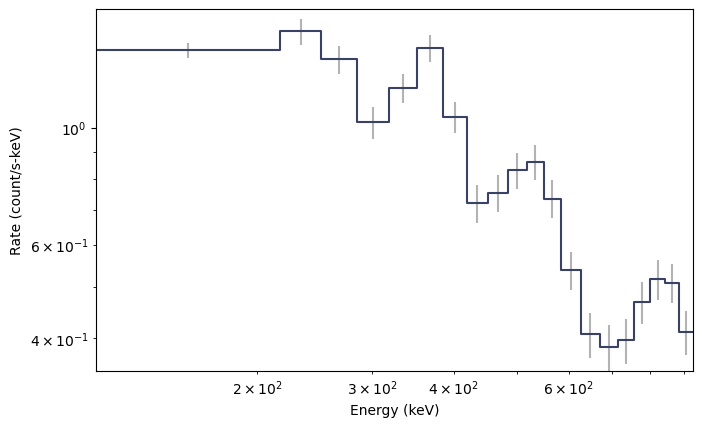

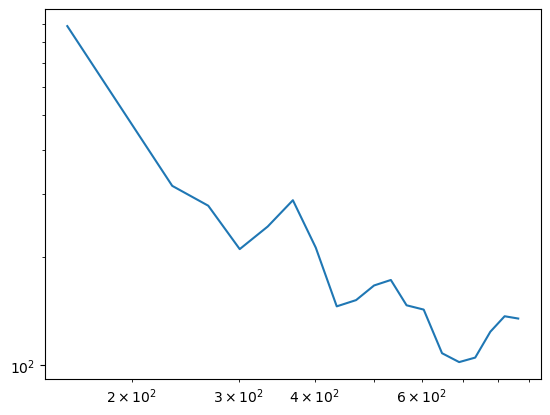

In [32]:
t90,t90_start 

# why the resolution
# lcplot = Lightcurve(data=lc_data)
# zoom in to 5 seconds before to 20 s after the trigger time
# view_range = (t90_start-3.0, t90_start+t90+20.0)
# lcplot.xlim = view_range
# # our lightcurve source selection
src_time = (t90_start, t90_start+t90)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

# lcplot = Lightcurve(data=lc_data)
# lcplot.add_selection(src_lc)
# lcplot.xlim = view_range  

# # the observed count spectrum during the source selection
spec_data = phaii.to_spectrum(time_range=src_time)
# # the background model integrated over the source selection time
# spec_bkgd = bkgd.integrate_time(*src_time)
# # and the energy range selection that was made
spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)

specplot = Spectrum(data=spec_selection)
# specplot.add_selection(spec_selection)

plt.figure()
c_erange = (spec_selection.centroids < max(erange)) * (spec_selection.centroids > min(erange))
plt.plot(spec_selection.centroids[c_erange],spec_selection.counts[c_erange])
plt.xscale('log')
plt.yscale('log')
np.savetxt('sample_energy_lc.txt',np.array([spec_selection.centroids[c_erange],spec_selection.counts[c_erange]]))
# spec_data.centroids[c_erange]

In [6]:
from gbm.finder import BurstCatalog
from gbm.finder import TriggerFtp
import os
    
import gbm
from gbm import test_data_dir
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
import glob
import matplotlib.pyplot as plt
import numpy as np
from gbm.plot import Lightcurve, Spectrum

from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count


# burstcat = BurstCatalog()

bursts = burstcat.get_table(columns=('name',
                                     'trigger_name', 
                                     't90',
                                     't90_start',
                                    ))

def lc_process(i):

    print(i,len(bursts.trigger_name),bursts.trigger_name[i])
    
    # initialize the Trigger data finder with a trigger number
    burst = bursts.trigger_name[i]
    trig_finder = TriggerFtp(burst[2:])

    #check if exists 
    path_tte = './Bursts/'+bursts.trigger_name[i]
    files_tte = glob.glob(path_tte+'/*tte*')
    
    if not len(files_tte) == 14 or not os.path.isdir(path_tte):
        trig_finder = TriggerFtp(burst[2:])
        trig_finder.get_tte(path_tte,verbose=False)
        print(burst,'restarted')
        
    else:
        print('TTE Downloaded')
        return

    
    temp_time = []
    temp_flux = []
    temp_idx = []
    temp_bg = []
    
    
    for ii in range(len(files_tte)):
    # open a TTE file
        tte = TTE.open(files_tte[ii])
        # bin to 1.024 s resolution, reference time is trigger time
        phaii = tte.to_phaii(bin_by_time, 1.024*2, time_ref=0.0)

        # maybe change the energy range??

        erange = (10.0, 900.0)

        lc_data = phaii.to_lightcurve(energy_range=erange)

        # lcplot = Lightcurve(data=lc_data)
        bg = np.median(lc_data.counts)
        t90 = bursts.t90[i]
        t90_start = bursts.t90_start[i]

        # median and std of the t90 region
        cond_bg_t90 = (lc_data.centroids>(t90_start-15)) * (lc_data.centroids<(t90_start+t90+35))
        cond_t90 = (lc_data.centroids>(t90_start)) * (lc_data.centroids<(t90_start+t90))
        std_bg_t90 = np.std(lc_data.counts[cond_bg_t90])
        median_t90 = np.max(lc_data.counts[cond_t90])-np.median(lc_data.counts[cond_bg_t90])
        SNR = median_t90/std_bg_t90

        if SNR > 3:
            print(ii,median_t90,std_bg_t90,median_t90/std_bg_t90)
            temp_time.append(lc_data.centroids[1:-1])
            temp_flux.append(lc_data.counts[1:-1])
            temp_idx.append(ii)
            temp_bg.append(bg)

            det = files_tte[ii][files_tte[ii].rfind('glg_tte_')+8:files_tte[ii].rfind('glg_tte_')+8+2]
            lc_name = f'lc_{burst}_{det}_{int(t90_start)}_{int(t90)}_{np.round(SNR)}.txt'
            np.savetxt(path_tte+'/'+lc_name,np.array([lc_data.centroids[1:-1],lc_data.counts[1:-1]]))
            
    fig, axs = plt.subplots(len(temp_flux), 1, figsize=(6, 2*len(temp_flux)))
    for j,ax in enumerate(axs.flat):
        ax.set_title(temp_idx[j])
        ax.vlines(t90_start-15,temp_bg[j]-100,temp_bg[j]+100,color='red')
        ax.vlines(t90_start+t90+35,temp_bg[j]-100,temp_bg[j]+100,color='red')
        ax.vlines(t90_start,temp_bg[j]-100,temp_bg[j]+100)
        ax.vlines(t90_start+t90,temp_bg[j]-100,temp_bg[j]+100)
        ax.plot(temp_time[j],temp_flux[j])
    fig.savefig(path_tte+'/'+f'collage_{burst}.png',dpi=200)
    fig.clf()

    os.system('rm '+path_tte+'/*.fits')
    
    return

with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
#     executor.map(rename_function, range(len(bursts.trigger_name)))
    executor.map(l, np.arange(7))

NameError: name 'rename_function' is not defined

In [2]:
# theo parallel

from gbm.finder import BurstCatalog
from gbm.finder import TriggerFtp
import os
    
import gbm
from gbm import test_data_dir
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
import glob
import matplotlib.pyplot as plt
import numpy as np
from gbm.plot import Lightcurve, Spectrum

from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count


# burstcat = BurstCatalog()

bursts = burstcat.get_table(columns=('name',
                                     'trigger_name', 
                                     't90',
                                     't90_start',
                                    ))

def download(i):
    print(i,len(bursts.trigger_name),bursts.trigger_name[i])
    
    # initialize the Trigger data finder with a trigger number
    burst = bursts.trigger_name[i]
    trig_finder = TriggerFtp(burst[2:])

    #check if exists 
    path_tte = './Bursts/'+bursts.trigger_name[i]
    
    if not os.path.isdir(path_tte):
        trig_finder.get_tte(path_tte,verbose=False)
        
    else:
        print('TTE Downloaded')
        return
    
with ThreadPoolExecutor(max_workers=cpu_count()-3) as executor:
    executor.map(download, range(len(bursts.trigger_name)))

01 3567 bn120227725
 3567 bn120403857
2 3567 bn230524357
3 3567 bn210411564
4 3567 bn190304818
5 3567 bn141205018
6 3567 bn180630467
7 3567 bn170116238
8 3567 bn091026550
9 3567 bn230428381
10 3567 bn150312403
11 3567 bn190825171
12 3567 bn080714425
13 3567 bn110520302
14 3567 bn121216419
15 3567 bn200107810
16 3567 bn190422284
17 3567 bn101227195
18 3567 bn220430900
19 3567 bn200607921
20 3567 bn160326062
21 3567 bn230426853
22 3567 bn220413167
23 3567 bn230415474
24 3567 bn101116481
25 3567 bn220921473
26 3567 bn170130697
27 3567 bn221203537
28 3567 bn110205027
29 3567 bn110825265
30 3567 bn160919613
31 3567 bn120830212
32 3567 bn140323433
33 3567 bn220415645
34 3567 bn181007737
35 3567 bn180723133
Connection appears to have failed.  Attempting to reconnect...
36 3567 bn100325246
Connection appears to have failed.  Attempting to reconnect...
37 3567 bn100507577
Connection appears to have failed.  Attempting to reconnect...
38 3567 bn200907957
Connection appears to have failed.  Attem

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn110911071_v00.fit [==============================] 100.00%
glg_tte_b1_bn120227725_v00.fit [========================      ] 82.37%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn100325246_v00.fit [==============================] 100.00%
glg_tte_b0_bn180723133_v00.fit [==============================] 100.00%
glg_tte_n0_bn100507577_v00.fit [==============================] 100.00%
glg_tte_n0_bn120227725_v00.fit [==============================] 100.00%
glg_tte_b0_bn200907957_v00.fit [==============================] 100.00%
glg_tte_b1_bn180906597_v00.fit [==================            ] 61.29%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn180906597_v00.fit [==============================] 100.00%
glg_tte_b1_bn180723133_v00.fit [==============================] 100.00%
glg_tte_n1_bn100507577_v00.fit [==============================] 100.00%
glg_tte_n1_bn120227725_v00.fit [==============================] 100.00%
glg_tte_n0_bn110911071_v00.fit [==============================] 100.00%
glg_tte_b1_bn200907957_v00.fit [===================           ] 64.26%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n2_bn120227725_v00.fit [==============================] 100.00%
glg_tte_n0_bn180723133_v00.fit [==============================] 100.00%
glg_tte_n2_bn100507577_v00.fit [==============================] 100.00%
glg_tte_n1_bn110911071_v00.fit [==============================] 100.00%
glg_tte_n2_bn100325246_v00.fit [==============================] 100.00%
glg_tte_n0_bn200907957_v00.fit [=================             ] 58.66%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn100507577_v00.fit [==============================] 100.00%
glg_tte_n1_bn180723133_v00.fit [==============================] 100.00%
glg_tte_n3_bn100325246_v00.fit [==============================] 100.00%
glg_tte_n2_bn110911071_v00.fit [==============================] 100.00%
glg_tte_n1_bn200907957_v00.fit [=========                     ] 30.55%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn110911071_v00.fit [==============================] 100.00%
glg_tte_n2_bn180723133_v00.fit [==============================] 100.00%
glg_tte_n4_bn100325246_v00.fit [==============================] 100.00%
glg_tte_n5_bn120227725_v00.fit [==============================] 100.00%
glg_tte_n3_bn180906597_v00.fit [==============================] 100.00%
glg_tte_n3_bn180723133_v00.fit [=====                         ] 19.08%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n5_bn100507577_v00.fit [==============================] 100.00%
glg_tte_n3_bn180723133_v00.fit [==============================] 100.00%
glg_tte_n6_bn120227725_v00.fit [==============================] 100.00%
glg_tte_n4_bn110911071_v00.fit [==============================] 100.00%
glg_tte_n4_bn180906597_v00.fit [==============================] 100.00%
glg_tte_n2_bn200907957_v00.fit [===================           ] 66.03%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n7_bn120227725_v00.fit [==============================] 100.00%
glg_tte_n4_bn180723133_v00.fit [==============================] 100.00%
glg_tte_n5_bn110911071_v00.fit [==============================] 100.00%
glg_tte_n5_bn180906597_v00.fit [==============================] 100.00%
glg_tte_n7_bn100325246_v00.fit [==============================] 100.00%
glg_tte_n3_bn200907957_v00.fit [==============================] 100.00%
glg_tte_n6_bn180906597_v00.fit [=========                     ] 30.70%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n8_bn120227725_v00.fit [==============================] 100.00%
glg_tte_n6_bn180906597_v00.fit [==============================] 100.00%
glg_tte_n8_bn100325246_v00.fit [==============================] 100.00%
glg_tte_n6_bn110911071_v00.fit [==============================] 100.00%
glg_tte_n7_bn100507577_v00.fit [==============================] 100.00%
glg_tte_n7_bn110911071_v00.fit [===============               ] 51.07%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n7_bn110911071_v00.fit [==============================] 100.00%
glg_tte_n7_bn180906597_v00.fit [==============================] 100.00%
glg_tte_n9_bn100325246_v00.fit [==============================] 100.00%
glg_tte_n4_bn200907957_v00.fit [==============================] 100.00%
glg_tte_n8_bn100507577_v00.fit [==============================] 100.00%
glg_tte_na_bn120227725_v00.fit [==============================] 100.00%
glg_tte_n8_bn110911071_v00.fit [==============================] 100.00%
glg_tte_na_bn100325246_v00.fit [========================      ] 82.69%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n7_bn180723133_v00.fit [==============================] 100.00%
glg_tte_n9_bn100507577_v00.fit [==============================] 100.00%
glg_tte_nb_bn120227725_v00.fit [==============================] 100.00%
glg_tte_n9_bn180906597_v00.fit [                              ] 2.70%%41 3567 bn200908886
Connection appears to have failed.  Attempting to reconnect...
glg_tte_n9_bn110911071_v00.fit [==============================] 100.00%
glg_tte_nb_bn100325246_v00.fit [=========                     ] 33.21%Reconnected.
glg_tte_n5_bn200907957_v00.fit [============================= ] 97.04%%
glg_tte_n9_bn180906597_v00.fit [==============                ] 48.81%42 3567 bn171206122
Connection appears to have failed.  Attempting to reconnect...
glg_tte_n5_bn200907957_v00.fit [==============================] 100.00%
glg_tte_na_bn100507577_v00.fit [==================            ] 60.67%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n8_bn180723133_v00.fit [==============================] 100.00%
glg_tte_na_bn110911071_v00.fit [==============================] 100.00%
glg_tte_nb_bn100507577_v00.fit [===============               ] 51.88%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n9_bn180723133_v00.fit [======================        ] 74.85%Reconnected.
glg_tte_nb_bn110911071_v00.fit [==============================] 100.00%
glg_tte_b0_bn171206122_v00.fit [==============================] 100.00%
glg_tte_n9_bn180723133_v00.fit [==============================] 100.00%
44 3567 bn130623488
Connection appears to have failed.  Attempting to reconnect...
glg_tte_na_bn180906597_v00.fit [==============================] 100.00%
glg_tte_n7_bn200907957_v00.fit [=======                       ] 23.90%Reconnected.
glg_tte_na_bn180723133_v00.fit [===                           ] 13.14%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn200908886_v00.fit [==============================] 100.00%
glg_tte_nb_bn180906597_v00.fit [==============================] 100.00%
glg_tte_b1_bn171206122_v00.fit [========================      ] 80.30%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b0_bn140518709_v00.fit [====================          ] 69.09%%
glg_tte_n8_bn200907957_v00.fit [==============================] 100.00%
glg_tte_n0_bn200908886_v00.fit [===========                   ] 38.94%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b0_bn130623488_v00.fit [==============================] 100.00%
glg_tte_b0_bn141004150_v00.fit [========                      ] 29.97%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n9_bn200907957_v00.fit [==============================] 100.00%
glg_tte_n1_bn200908886_v00.fit [                              ] 3.08%%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_nb_bn180723133_v00.fit [==============================] 100.00%
glg_tte_na_bn200907957_v00.fit [                              ] 1.29%%46 3567 bn101024486
Connection appears to have failed.  Attempting to reconnect...
glg_tte_b1_bn140518709_v00.fit [==============================] 100.00%
glg_tte_n1_bn200908886_v00.fit [=================             ] 58.97%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_na_bn200907957_v00.fit [==============================] 100.00%
glg_tte_b1_bn141004150_v00.fit [======================        ] 75.26%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn130623488_v00.fit [==============================] 100.00%
glg_tte_b1_bn141004150_v00.fit [==============================] 100.00%
glg_tte_n0_bn140518709_v00.fit [==========================    ] 88.72%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_nb_bn200907957_v00.fit [==============================] 100.00%
glg_tte_n2_bn171206122_v00.fit [==============================] 100.00%
glg_tte_n0_bn141004150_v00.fit [==                            ] 6.81% 3567 bn200119692
Connection appears to have failed.  Attempting to reconnect...
glg_tte_b0_bn101024486_v00.fit [===============               ] 52.85%Reconnected.
glg_tte_n0_bn130623488_v00.fit [==============================] 100.00%
glg_tte_n3_bn200908886_v00.fit [=========                     ] 31.46%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n1_bn140518709_v00.fit [==============================] 100.00%
glg_tte_b0_bn101024486_v00.fit [==============================] 100.00%
glg_tte_n3_bn171206122_v00.fit [=================             ] 56.87%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn171206122_v00.fit [==============================] 100.00%
glg_tte_n1_bn130623488_v00.fit [==============================] 100.00%
glg_tte_n2_bn140518709_v00.fit [==============================] 100.00%
glg_tte_b0_bn200119692_v00.fit [========                      ] 28.85%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn101024486_v00.fit [====================          ] 67.26%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n4_bn171206122_v00.fit [==============================] 100.00%
glg_tte_n2_bn141004150_v00.fit [==============================] 100.00%
glg_tte_n0_bn101024486_v00.fit [==============================] 100.00%
glg_tte_n2_bn130623488_v00.fit [==============================] 100.00%
glg_tte_n3_bn141004150_v00.fit [==============================] 100.00%
glg_tte_n3_bn140518709_v00.fit [==============================] 100.00%
glg_tte_n1_bn101024486_v00.fit [==============================] 100.00%
glg_tte_n5_bn171206122_v00.fit [==============================] 100.00%
glg_tte_n4_bn141004150_v00.fit [==============================] 100.00%
glg_tte_n5_bn200908886_v00.fit [=========================     ] 84.84%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n6_bn171206122_v00.fit [==============================] 100.00%
glg_tte_n2_bn101024486_v00.fit [==============================] 100.00%
glg_tte_n3_bn130623488_v00.fit [==============================] 100.00%
glg_tte_n5_bn141004150_v00.fit [==============================] 100.00%
glg_tte_b0_bn200119692_v00.fit [==============================] 100.00%
glg_tte_n5_bn140518709_v00.fit [==============================] 100.00%
glg_tte_n7_bn171206122_v00.fit [========                      ] 27.41%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n4_bn130623488_v00.fit [==============================] 100.00%
glg_tte_n6_bn141004150_v00.fit [==============================] 100.00%
glg_tte_n6_bn200908886_v00.fit [==============================] 100.00%
glg_tte_n7_bn171206122_v00.fit [==============================] 100.00%
glg_tte_n4_bn101024486_v00.fit [==========================    ] 88.24%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn200119692_v00.fit [===============               ] 52.95%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n6_bn140518709_v00.fit [==============================] 100.00%
glg_tte_n7_bn141004150_v00.fit [==============================] 100.00%
glg_tte_n7_bn200908886_v00.fit [==============================] 100.00%
glg_tte_n7_bn140518709_v00.fit [=========                     ] 30.05%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n5_bn101024486_v00.fit [==============================] 100.00%
glg_tte_n8_bn200908886_v00.fit [==============================] 100.00%
glg_tte_n7_bn140518709_v00.fit [==============================] 100.00%
glg_tte_n9_bn171206122_v00.fit [=======================       ] 79.51%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n9_bn171206122_v00.fit [==============================] 100.00%
glg_tte_n0_bn200119692_v00.fit [==============================] 100.00%
glg_tte_n9_bn200908886_v00.fit [==============================] 100.00%
glg_tte_n8_bn141004150_v00.fit [==============================] 100.00%
glg_tte_n8_bn140518709_v00.fit [==============================] 100.00%
glg_tte_n9_bn141004150_v00.fit [===                           ] 10.65%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_na_bn200908886_v00.fit [==============================] 100.00%
glg_tte_n1_bn200119692_v00.fit [===========================   ] 92.84%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n9_bn141004150_v00.fit [==============================] 100.00%
glg_tte_nb_bn200908886_v00.fit [==============================] 100.00%
glg_tte_n8_bn101024486_v00.fit [===========================   ] 93.08%48 3567 bn210919653
Connection appears to have failed.  Attempting to reconnect...
glg_tte_n8_bn101024486_v00.fit [==============================] 100.00%
glg_tte_nb_bn171206122_v00.fit [====================          ] 68.98%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_na_bn141004150_v00.fit [==============================] 100.00%
glg_tte_nb_bn141004150_v00.fit [===========                   ] 39.25%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn200119692_v00.fit [==============================] 100.00%
glg_tte_nb_bn141004150_v00.fit [==============================] 100.00%
glg_tte_b0_bn210919653_v00.fit [===========                   ] 39.04%50 3567 bn190628521
Connection appears to have failed.  Attempting to reconnect...
glg_tte_b0_bn210919653_v00.fit [=============                 ] 45.41%Reconnected.
glg_tte_na_bn140518709_v00.fit [==============================] 100.00%
glg_tte_na_bn101024486_v00.fit [==============================] 100.00%
glg_tte_b0_bn210919653_v00.fit [========================      ] 81.11%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_nb_bn140518709_v00.fit [========                      ] 29.97%Reconnected.
glg_tte_b0_bn210919653_v00.fit [==============================] 100.00%
glg_tte_b0_bn210826293_v00.fit [===========================   ] 93.11%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b0_bn200629535_v00.fit [                              ] 1.98%Reconnected.
glg_tte_b0_bn200629535_v00.fit [=                             ] 5.03%Reconnected.
glg_tte_n5_bn200119692_v00.fit [=======================       ] 79.10%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn190628521_v00.fit [==============================] 100.00%
glg_tte_b0_bn220315101_v00.fit [==============================] 100.00%
glg_tte_b1_bn210919653_v00.fit [==============================] 100.00%
glg_tte_n0_bn190628521_v00.fit [==                            ] 6.93%%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n0_bn190628521_v00.fit [==============================] 100.00%
glg_tte_b1_bn200629535_v00.fit [==============================] 100.00%
glg_tte_b1_bn220315101_v00.fit [===================           ] 65.95%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b0_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n0_bn200629535_v00.fit [==============================] 100.00%
glg_tte_n1_bn190628521_v00.fit [==============================] 100.00%
glg_tte_n1_bn210826293_v00.fit [=================             ] 57.82%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n1_bn200629535_v00.fit [==============================] 100.00%
glg_tte_n2_bn190628521_v00.fit [==============================] 100.00%
glg_tte_n0_bn110716018_v00.fit [==============                ] 47.84%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n0_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n2_bn200629535_v00.fit [==============================] 100.00%
glg_tte_n3_bn190628521_v00.fit [==============================] 100.00%
glg_tte_n1_bn220315101_v00.fit [==============================] 100.00%
glg_tte_n2_bn210919653_v00.fit [==============================] 100.00%
glg_tte_n3_bn200629535_v00.fit [==                            ] 8.00%%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn200629535_v00.fit [==============================] 100.00%
glg_tte_n2_bn210826293_v00.fit [==============================] 100.00%
glg_tte_n2_bn110716018_v00.fit [=====================         ] 70.72%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n4_bn200629535_v00.fit [===================           ] 65.91%Reconnected.
glg_tte_n4_bn200629535_v00.fit [==============================] 100.00%
glg_tte_n3_bn210826293_v00.fit [==============================] 100.00%
glg_tte_n3_bn220315101_v00.fit [==============                ] 49.80%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn220315101_v00.fit [==============================] 100.00%
glg_tte_b0_bn110819665_v00.fit [==============================] 100.00%
glg_tte_n5_bn200629535_v00.fit [==============================] 100.00%
glg_tte_n4_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n4_bn220315101_v00.fit [======                        ] 23.22%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n4_bn220315101_v00.fit [==============================] 100.00%
glg_tte_n5_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n6_bn200629535_v00.fit [==============================] 100.00%
glg_tte_b1_bn110819665_v00.fit [==============================] 100.00%
glg_tte_n6_bn190628521_v00.fit [==============================] 100.00%
glg_tte_n5_bn210826293_v00.fit [==============================] 100.00%
glg_tte_n6_bn210919653_v00.fit [=================             ] 57.89%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n6_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n0_bn110819665_v00.fit [==============================] 100.00%
glg_tte_n5_bn220315101_v00.fit [==============================] 100.00%
glg_tte_n7_bn200629535_v00.fit [=====================         ] 71.27%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n7_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n1_bn110819665_v00.fit [==============================] 100.00%
glg_tte_n8_bn190628521_v00.fit [=============                 ] 43.95%%
glg_tte_n8_bn190628521_v00.fit [==============================] 100.00%
glg_tte_n8_bn210919653_v00.fit [============                  ] 42.54%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n8_bn210919653_v00.fit [==============================] 100.00%
glg_tte_n7_bn220315101_v00.fit [==============================] 100.00%
glg_tte_n3_bn110819665_v00.fit [==============================] 100.00%
glg_tte_n9_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n8_bn200629535_v00.fit [==============================] 100.00%
glg_tte_n9_bn190628521_v00.fit [============================= ] 97.72%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n8_bn220315101_v00.fit [==============================] 100.00%
glg_tte_n4_bn110819665_v00.fit [==============================] 100.00%
glg_tte_n8_bn210826293_v00.fit [==============================] 100.00%
glg_tte_na_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n9_bn220315101_v00.fit [=                             ] 4.25%%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_nb_bn110716018_v00.fit [==============================] 100.00%
glg_tte_n5_bn110819665_v00.fit [==============================] 100.00%
glg_tte_nb_bn190628521_v00.fit [=                             ] 4.06% 3567 bn190731943
Connection appears to have failed.  Attempting to reconnect...
glg_tte_n9_bn220315101_v00.fit [==============================] 100.00%
glg_tte_n9_bn210826293_v00.fit [==============================] 100.00%
glg_tte_nb_bn190628521_v00.fit [=======                       ] 23.76%Reconnected.
glg_tte_na_bn200629535_v00.fit [==============================] 100.00%
glg_tte_nb_bn190628521_v00.fit [======================        ] 74.95%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_na_bn210826293_v00.fit [================              ] 54.52%Reconnected.
glg_tte_na_bn210826293_v00.fit [==============================] 100.00%
glg_tte_n6_bn110819665_v00.fit [==============================] 100.00%
glg_tte_nb_bn200629535_v00.fit [==============================] 100.00%
glg_tte_na_bn210919653_v00.fit [=====                         ] 17.43% 3567 bn090810659
Connection appears to have failed.  Attempting to reconnect...
glg_tte_na_bn220315101_v00.fit [==============================] 100.00%
glg_tte_b0_bn190731943_v00.fit [======================        ] 74.00%Reconnected.
glg_tte_b0_bn190731943_v00.fit [==========================    ] 86.87%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n7_bn110819665_v00.fit [==============================] 100.00%
glg_tte_nb_bn210826293_v00.fit [==============================] 100.00%
glg_tte_b0_bn181022846_v00.fit [==============                ] 47.69%58 3567 bn180622273
Connection appears to have failed.  Attempting to reconnect...
glg_tte_b0_bn181022846_v00.fit [=======================       ] 78.89%Reconnected.
glg_tte_b0_bn181022846_v00.fit [==============================] 100.00%
glg_tte_nb_bn220315101_v00.fit [==============================] 100.00%
glg_tte_b0_bn090810659_v00.fit [=============                 ] 46.23%59 3567 bn160406570
Connection appears to have failed.  Attempting to reconnect...
glg_tte_n8_bn110819665_v00.fit [==============                ] 47.10%Reconnected.
glg_tte_b0_bn090810659_v00.fit [==============================] 100.00%
glg_tte_n8_bn110819665_v00.fit [==============================] 100.00%
glg_tte_b0_bn180622273_v00.fit [=============                 ] 45.44%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_na_bn210919653_v00.fit [==============================] 100.00%
glg_tte_n9_bn110819665_v00.fit [==============================] 100.00%
glg_tte_b1_bn181022846_v00.fit [==============================] 100.00%
glg_tte_b0_bn160406570_v00.fit [==============================] 100.00%
glg_tte_n0_bn090810659_v00.fit [==============================] 100.00%
glg_tte_b0_bn180622273_v00.fit [==============================] 100.00%
glg_tte_nb_bn210919653_v00.fit [============                  ] 41.36%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_nb_bn210919653_v00.fit [==============================] 100.00%
glg_tte_b1_bn180622273_v00.fit [==                            ] 9.18%%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n1_bn090810659_v00.fit [==============================] 100.00%
glg_tte_b1_bn160406570_v00.fit [=====================         ] 71.38%Reconnected.
glg_tte_nb_bn110819665_v00.fit [==============================] 100.00%
glg_tte_b1_bn180622273_v00.fit [=========                     ] 31.37%61 3567 bn161020759
Connection appears to have failed.  Attempting to reconnect...
glg_tte_b1_bn160406570_v00.fit [==============================] 100.00%
glg_tte_b1_bn190731943_v00.fit [==============================] 100.00%
glg_tte_b1_bn180622273_v00.fit [============                  ] 42.59%Reconnected.
glg_tte_n2_bn090810659_v00.fit [==============================] 100.00%
glg_tte_b0_bn161020759_v00.fit [                              ] 0.86%%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n1_bn181022846_v00.fit [==============================] 100.00%
glg_tte_b1_bn180622273_v00.fit [==============================] 100.00%
glg_tte_b1_bn130804023_v00.fit [==============================] 100.00%
glg_tte_n3_bn090810659_v00.fit [==============================] 100.00%
glg_tte_n2_bn181022846_v00.fit [=================             ] 56.98%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n1_bn130804023_v00.fit [==============================] 100.00%
glg_tte_n4_bn090810659_v00.fit [==============================] 100.00%
glg_tte_n2_bn130804023_v00.fit [==============================] 100.00%
glg_tte_n3_bn181022846_v00.fit [================              ] 54.60%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn181022846_v00.fit [==============================] 100.00%
glg_tte_n4_bn130804023_v00.fit [==============================] 100.00%
glg_tte_b1_bn161020759_v00.fit [=========================     ] 84.42%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n6_bn130804023_v00.fit [==============================] 100.00%
glg_tte_n7_bn090810659_v00.fit [==============================] 100.00%
glg_tte_n3_bn180622273_v00.fit [============================  ] 93.67%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n8_bn090810659_v00.fit [==============================] 100.00%
glg_tte_n9_bn130804023_v00.fit [==============================] 100.00%
glg_tte_n4_bn180622273_v00.fit [==============================] 100.00%
glg_tte_n4_bn160406570_v00.fit [==============================] 100.00%
glg_tte_n4_bn190731943_v00.fit [==============================] 100.00%
glg_tte_n9_bn090810659_v00.fit [============                  ] 40.19%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_nb_bn130804023_v00.fit [==============================] 100.00%
glg_tte_n7_bn181022846_v00.fit [====                          ] 13.71%62 3567 bn120114433
Connection appears to have failed.  Attempting to reconnect...
glg_tte_n2_bn161020759_v00.fit [==============                ] 49.66%Reconnected.
glg_tte_na_bn090810659_v00.fit [==============================] 100.00%
glg_tte_n5_bn160406570_v00.fit [==============================] 100.00%
glg_tte_n5_bn180622273_v00.fit [==============================] 100.00%
glg_tte_n2_bn161020759_v00.fit [=====================         ] 72.28%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_nb_bn090810659_v00.fit [==============================] 100.00%
glg_tte_n6_bn190731943_v00.fit [========                      ] 29.36%63 3567 bn170121067
Connection appears to have failed.  Attempting to reconnect...
glg_tte_n6_bn190731943_v00.fit [================              ] 56.43%Reconnected.
glg_tte_n8_bn181022846_v00.fit [==============================] 100.00%
glg_tte_n6_bn180622273_v00.fit [========================      ] 80.29%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n6_bn160406570_v00.fit [==============================] 100.00%
glg_tte_n9_bn181022846_v00.fit [==============================] 100.00%
glg_tte_n7_bn160406570_v00.fit [=                             ] 4.25%%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n7_bn180622273_v00.fit [==============================] 100.00%
glg_tte_n7_bn160406570_v00.fit [==============================] 100.00%
glg_tte_n3_bn161020759_v00.fit [==============================] 100.00%
glg_tte_n8_bn190731943_v00.fit [==============================] 100.00%
glg_tte_na_bn181022846_v00.fit [==============================] 100.00%
glg_tte_n8_bn180622273_v00.fit [==                            ] 6.82%%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n8_bn180622273_v00.fit [==============================] 100.00%
glg_tte_n4_bn161020759_v00.fit [==============================] 100.00%
glg_tte_n8_bn160406570_v00.fit [==============================] 100.00%
glg_tte_n1_bn120114433_v00.fit [==============================] 100.00%
glg_tte_n9_bn190731943_v00.fit [============================  ] 94.27%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n9_bn180622273_v00.fit [========================      ] 83.31%Reconnected.
glg_tte_n9_bn180622273_v00.fit [==============================] 100.00%
glg_tte_n2_bn120114433_v00.fit [==============================] 100.00%
glg_tte_n5_bn161020759_v00.fit [==============================] 100.00%
glg_tte_n1_bn170121067_v00.fit [===================           ] 66.25%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn120114433_v00.fit [==============================] 100.00%
glg_tte_n6_bn161020759_v00.fit [==============================] 100.00%
glg_tte_na_bn190731943_v00.fit [==============================] 100.00%
glg_tte_na_bn160406570_v00.fit [==================            ] 63.10%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_na_bn180622273_v00.fit [==============================] 100.00%
glg_tte_n4_bn120114433_v00.fit [==============================] 100.00%
glg_tte_n7_bn161020759_v00.fit [==============================] 100.00%
glg_tte_nb_bn190731943_v00.fit [==============================] 100.00%
glg_tte_nb_bn160406570_v00.fit [==========                    ] 33.64%65 3567 bn230307656
Connection appears to have failed.  Attempting to reconnect...
glg_tte_b0_bn170124874_v00.fit [==============================] 100.00%
glg_tte_nb_bn180622273_v00.fit [=                             ] 4.23%Reconnected.
glg_tte_n3_bn170121067_v00.fit [=====================         ] 71.03%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n8_bn161020759_v00.fit [==============================] 100.00%
glg_tte_b0_bn230307656_v00.fit [================              ] 54.30%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b0_bn190806675_v00.fit [==============================] 100.00%
glg_tte_n0_bn170124874_v00.fit [============                  ] 40.68%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn230307656_v00.fit [==============================] 100.00%
glg_tte_n0_bn170124874_v00.fit [==============================] 100.00%
glg_tte_b1_bn190806675_v00.fit [==============================] 100.00%
glg_tte_nb_bn180622273_v00.fit [=========================     ] 83.43%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n0_bn230307656_v00.fit [=================             ] 59.45%67 3567 bn210721978
Connection appears to have failed.  Attempting to reconnect...
glg_tte_na_bn161020759_v00.fit [==============================] 100.00%
glg_tte_n0_bn230307656_v00.fit [===========================   ] 92.06%Reconnected.
glg_tte_n0_bn230307656_v00.fit [==============================] 100.00%
glg_tte_n1_bn170124874_v00.fit [==============================] 100.00%
glg_tte_n0_bn190806675_v00.fit [==============================] 100.00%
glg_tte_n9_bn120114433_v00.fit [==============================] 100.00%
glg_tte_n7_bn170121067_v00.fit [=======                       ] 25.83%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_na_bn120114433_v00.fit [==============================] 100.00%
glg_tte_n1_bn230307656_v00.fit [==============================] 100.00%
glg_tte_nb_bn161020759_v00.fit [==========================    ] 89.49%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_nb_bn120114433_v00.fit [==============================] 100.00%
glg_tte_b0_bn210721978_v00.fit [=========                     ] 32.13%69 3567 bn211219910
Connection appears to have failed.  Attempting to reconnect...
glg_tte_b0_bn210721978_v00.fit [==========                    ] 36.52%Reconnected.
glg_tte_b0_bn211219910_v00.fit [==========                    ] 34.30%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n2_bn190806675_v00.fit [==============================] 100.00%
glg_tte_b0_bn190921699_v00.fit [==============================] 100.00%
glg_tte_n3_bn170124874_v00.fit [==============================] 100.00%
glg_tte_b0_bn211219910_v00.fit [==============================] 100.00%
glg_tte_b0_bn210721978_v00.fit [==============================] 100.00%
glg_tte_n2_bn230307656_v00.fit [==============================] 100.00%
glg_tte_n8_bn170121067_v00.fit [==============================] 100.00%
glg_tte_n3_bn190806675_v00.fit [==============================] 100.00%
glg_tte_b1_bn190921699_v00.fit [===============               ] 51.28%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn190921699_v00.fit [==============================] 100.00%
glg_tte_n4_bn190806675_v00.fit [===                           ] 10.79%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n3_bn230307656_v00.fit [==============================] 100.00%
glg_tte_b1_bn211219910_v00.fit [==============================] 100.00%
glg_tte_n9_bn170121067_v00.fit [==============================] 100.00%
glg_tte_b1_bn210721978_v00.fit [===================           ] 66.28%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_b1_bn210721978_v00.fit [============================= ] 98.26%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n0_bn211219910_v00.fit [==============================] 100.00%
glg_tte_na_bn170121067_v00.fit [==============================] 100.00%
glg_tte_n5_bn190806675_v00.fit [===================           ] 64.84%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n5_bn190806675_v00.fit [==============================] 100.00%
glg_tte_n0_bn210721978_v00.fit [==============================] 100.00%
glg_tte_n1_bn190921699_v00.fit [==============================] 100.00%
glg_tte_n6_bn190806675_v00.fit [===                           ] 12.71%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n1_bn211219910_v00.fit [==============================] 100.00%
glg_tte_n2_bn190921699_v00.fit [=========                     ] 32.54%Reconnected.
glg_tte_n5_bn230307656_v00.fit [==============================] 100.00%
glg_tte_n1_bn210721978_v00.fit [==============================] 100.00%
glg_tte_n6_bn190806675_v00.fit [==============================] 100.00%
glg_tte_n2_bn190921699_v00.fit [==============================] 100.00%
glg_tte_n2_bn211219910_v00.fit [======                        ] 20.60%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n6_bn230307656_v00.fit [==================            ] 61.31%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n6_bn230307656_v00.fit [==============================] 100.00%
glg_tte_n3_bn190921699_v00.fit [==============================] 100.00%
glg_tte_b0_bn180614327_v00.fit [==============================] 100.00%
glg_tte_n6_bn170124874_v00.fit [==============================] 100.00%
glg_tte_n2_bn210721978_v00.fit [==============================] 100.00%
glg_tte_n4_bn190921699_v00.fit [==========                    ] 36.36%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n7_bn230307656_v00.fit [==============================] 100.00%
glg_tte_n7_bn170124874_v00.fit [==============================] 100.00%
glg_tte_n9_bn190806675_v00.fit [======                        ] 21.44%%
glg_tte_n5_bn190921699_v00.fit [==============                ] 49.97%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n8_bn170124874_v00.fit [==============================] 100.00%
glg_tte_n8_bn230307656_v00.fit [==============================] 100.00%
glg_tte_n5_bn211219910_v00.fit [=========                     ] 32.70%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



glg_tte_n5_bn211219910_v00.fit [==============================] 100.00%
glg_tte_n9_bn190806675_v00.fit [==============================] 100.00%
glg_tte_n9_bn170124874_v00.fit [==============================] 100.00%
glg_tte_n9_bn230307656_v00.fit [==============                ] 47.20%

In [ ]:
# check if they have the 14 files

def check_download(i):
    
    burst = bursts.trigger_name[i] 
    path_tte = './Bursts/'+burst
    files = glob.glob(path_tte+'/*tte*')
    
    if not len(files) == 14:
        trig_finder = TriggerFtp(burst[2:])
        trig_finder.get_tte(path_tte,verbose=False)
        print(burst,'restarted')
    else:
        print(burst,'all TTE Downloaded')
        return
    
with ThreadPoolExecutor(max_workers=cpu_count()-3) as executor:
    executor.map(download, range(len(bursts.trigger_name)))

In [ ]:
for i in range(len(bursts.trigger_name)):
    # initialize the Trigger data finder with a trigger number
    burst = bursts.trigger_name[i]
    trig_finder = TriggerFtp(burst[2:])

    #check if exists 
    path_tte = './Bursts/'+bursts.trigger_name[i]

    files_tte = glob.glob(path_tte+'/*tte*')
    
    temp_time = []
    temp_flux = []
    temp_idx = []
    temp_bg = []
    
    
    for ii in range(len(files_tte)):
    # open a TTE file
        tte = TTE.open(files_tte[ii])
        # bin to 1.024 s resolution, reference time is trigger time
        phaii = tte.to_phaii(bin_by_time, 1.024*2, time_ref=0.0)

        # maybe change the energy range??

        erange = (10.0, 900.0)

        lc_data = phaii.to_lightcurve(energy_range=erange)

        # lcplot = Lightcurve(data=lc_data)
        bg = np.median(lc_data.counts)
        t90 = bursts.t90[i]
        t90_start = bursts.t90_start[i]

        # median and std of the t90 region
        cond_bg_t90 = (lc_data.centroids>(t90_start-15)) * (lc_data.centroids<(t90_start+t90+35))
        cond_t90 = (lc_data.centroids>(t90_start)) * (lc_data.centroids<(t90_start+t90))
        std_bg_t90 = np.std(lc_data.counts[cond_bg_t90])
        median_t90 = np.max(lc_data.counts[cond_t90])-np.median(lc_data.counts[cond_bg_t90])
        SNR = median_t90/std_bg_t90

        if SNR > 3:
            print(ii,median_t90,std_bg_t90,median_t90/std_bg_t90)
            temp_time.append(lc_data.centroids[1:-1])
            temp_flux.append(lc_data.counts[1:-1])
            temp_idx.append(ii)
            temp_bg.append(bg)

            det = files_tte[ii][files_tte[ii].rfind('glg_tte_')+8:files_tte[ii].rfind('glg_tte_')+8+2]
            lc_name = f'lc_{burst}_{det}_{int(t90_start)}_{int(t90)}_{np.round(SNR)}.txt'
            np.savetxt(path_tte+'/'+lc_name,np.array([lc_data.centroids[1:-1],lc_data.counts[1:-1]]))
            
    fig, axs = plt.subplots(len(temp_flux), 1, figsize=(6, 2*len(temp_flux)))
    for j,ax in enumerate(axs.flat):
        ax.set_title(temp_idx[j])
        ax.vlines(t90_start-15,temp_bg[j]-100,temp_bg[j]+100,color='red')
        ax.vlines(t90_start+t90+35,temp_bg[j]-100,temp_bg[j]+100,color='red')
        ax.vlines(t90_start,temp_bg[j]-100,temp_bg[j]+100)
        ax.vlines(t90_start+t90,temp_bg[j]-100,temp_bg[j]+100)
        ax.plot(temp_time[j],temp_flux[j])
    fig.savefig(path_tte+'/'+f'collage_{burst}.png',dpi=200)
    fig.clf()
    plt.close()

In [24]:
bursts = burstcat.get_table(columns=('name',
                                     'trigger_name', 
                                     't90',
                                     't90_start',
                                    ))

# for i in range(len(bursts.trigger_name)):
for i in [0,1,2,3,4]:

    print(i,len(bursts.trigger_name),bursts.trigger_name[i])
    
    # initialize the Trigger data finder with a trigger number
    burst = bursts.trigger_name[i]
    trig_finder = TriggerFtp(burst[2:])

    #check if exists 
    path_tte = './Bursts/'+bursts.trigger_name[i]
    
    if not os.path.isdir(path_tte):
        trig_finder.get_tte(path_tte)
        
    else:
        print('TTE Downloaded')
        continue

    files_tte = glob.glob(path_tte+'/*tte*')
    
    temp_time = []
    temp_flux = []
    temp_idx = []
    temp_bg = []
    
    
    for ii in range(len(files_tte)):
    # open a TTE file
        tte = TTE.open(files_tte[ii])
        # bin to 1.024 s resolution, reference time is trigger time
        phaii = tte.to_phaii(bin_by_time, 1.024*2, time_ref=0.0)

        # maybe change the energy range??

        erange = (10.0, 900.0)

        lc_data = phaii.to_lightcurve(energy_range=erange)

        # lcplot = Lightcurve(data=lc_data)
        bg = np.median(lc_data.counts)
        t90 = bursts.t90[i]
        t90_start = bursts.t90_start[i]

        # median and std of the t90 region
        cond_bg_t90 = (lc_data.centroids>(t90_start-15)) * (lc_data.centroids<(t90_start+t90+35))
        cond_t90 = (lc_data.centroids>(t90_start)) * (lc_data.centroids<(t90_start+t90))
        std_bg_t90 = np.std(lc_data.counts[cond_bg_t90])
        median_t90 = np.max(lc_data.counts[cond_t90])-np.median(lc_data.counts[cond_bg_t90])
        SNR = median_t90/std_bg_t90

        if SNR > 3:
            print(ii,median_t90,std_bg_t90,median_t90/std_bg_t90)
            temp_time.append(lc_data.centroids[1:-1])
            temp_flux.append(lc_data.counts[1:-1])
            temp_idx.append(ii)
            temp_bg.append(bg)

            det = files_tte[ii][files_tte[ii].rfind('glg_tte_')+8:files_tte[ii].rfind('glg_tte_')+8+2]
            lc_name = f'lc_{burst}_{det}_{int(t90_start)}_{int(t90)}_{np.round(SNR)}.txt'
            np.savetxt(path_tte+'/'+lc_name,np.array([lc_data.centroids[1:-1],lc_data.counts[1:-1]]))
            
    fig, axs = plt.subplots(len(temp_flux), 1, figsize=(6, 2*len(temp_flux)))
    for j,ax in enumerate(axs.flat):
        ax.set_title(temp_idx[j])
        ax.vlines(t90_start-15,temp_bg[j]-100,temp_bg[j]+100,color='red')
        ax.vlines(t90_start+t90+35,temp_bg[j]-100,temp_bg[j]+100,color='red')
        ax.vlines(t90_start,temp_bg[j]-100,temp_bg[j]+100)
        ax.vlines(t90_start+t90,temp_bg[j]-100,temp_bg[j]+100)
        ax.plot(temp_time[j],temp_flux[j])
    fig.savefig(path_tte+'/'+f'collage_{burst}.png',dpi=200)
    fig.clf()
        


0 3567 bn120403857
Connection appears to have failed.  Attempting to reconnect...
Reconnected.
glg_tte_b0_bn120403857_v00.fit [==============================] 100.00%
glg_tte_b1_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n0_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n1_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n2_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n3_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n4_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n5_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n6_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n7_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n8_bn120403857_v00.fit [==============================] 100.00%
glg_tte_n9_bn120403857_v00.fit [==============================] 100.00%
glg_tte_na_bn120403857_v00.fit [=========

<Figure size 600x600 with 0 Axes>

<Figure size 600x2000 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x1400 with 0 Axes>

In [ ]:
import sys, os
import zipfile
import requests
from multiprocessing import Pool, cpu_count
from functools import partial
from io import BytesIO



def download_lc(i):
    print(i,len(bursts.trigger_name),bursts.trigger_name[i])
    
    # initialize the Trigger data finder with a trigger number
    burst = bursts.trigger_name[i]
    trig_finder = TriggerFtp(burst[2:])

    #check if exists 
    path_tte = './Bursts/'+bursts.trigger_name[i]

    if not os.path.isdir(path_tte):
        trig_finder.get_tte(path_tte)

    else:
        print('TTE Downloaded')
#         continue

    files_tte = glob.glob(path_tte+'/*tte*')

    temp_time = []
    temp_flux = []
    temp_idx = []
    temp_bg = []


    for ii in range(len(files_tte)):
    # open a TTE file
        tte = TTE.open(files_tte[ii])
        # bin to 1.024 s resolution, reference time is trigger time
        phaii = tte.to_phaii(bin_by_time, 1.024*2, time_ref=0.0)

        # maybe change the energy range??

        erange = (10.0, 900.0)

        lc_data = phaii.to_lightcurve(energy_range=erange)

        # lcplot = Lightcurve(data=lc_data)
        bg = np.median(lc_data.counts)
        t90 = bursts.t90[i]
        t90_start = bursts.t90_start[i]

        # median and std of the t90 region
        cond_bg_t90 = (lc_data.centroids>(t90_start-15)) * (lc_data.centroids<(t90_start+t90+35))
        cond_t90 = (lc_data.centroids>(t90_start)) * (lc_data.centroids<(t90_start+t90))
        std_bg_t90 = np.std(lc_data.counts[cond_bg_t90])
        median_t90 = np.max(lc_data.counts[cond_t90])-np.median(lc_data.counts[cond_bg_t90])
        SNR = median_t90/std_bg_t90

        if SNR > 3:
            print(ii,median_t90,std_bg_t90,median_t90/std_bg_t90)
            temp_time.append(lc_data.centroids[1:-1])
            temp_flux.append(lc_data.counts[1:-1])
            temp_idx.append(ii)
            temp_bg.append(bg)

            det = files_tte[ii][files_tte[ii].rfind('glg_tte_')+8:files_tte[ii].rfind('glg_tte_')+8+2]
            lc_name = f'lc_{burst}_{det}_{int(t90_start)}_{int(t90)}_{np.round(SNR)}.txt'
            np.savetxt(path_tte+'/'+lc_name,np.array([lc_data.centroids[1:-1],lc_data.counts[1:-1]]))

    fig, axs = plt.subplots(len(temp_flux), 1, figsize=(6, 2*len(temp_flux)))
    for j,ax in enumerate(axs.flat):
        ax.set_title(temp_idx[j])
        ax.vlines(t90_start-15,temp_bg[j]-100,temp_bg[j]+100,color='red')
        ax.vlines(t90_start+t90+35,temp_bg[j]-100,temp_bg[j]+100,color='red')
        ax.vlines(t90_start,temp_bg[j]-100,temp_bg[j]+100)
        ax.vlines(t90_start+t90,temp_bg[j]-100,temp_bg[j]+100)
        ax.plot(temp_time[j],temp_flux[j])
    fig.savefig(path_tte+'/'+f'collage_{burst}.png',dpi=200)
    fig.clf()
    
print("There are {} CPUs on this machine ".format(cpu_count()))
pool = Pool(cpu_count()-4)

results = pool.starmap(download_lc,np.arange(35))
pool.close()
pool.join()

In [ ]:
results

In [11]:
plt.clf()

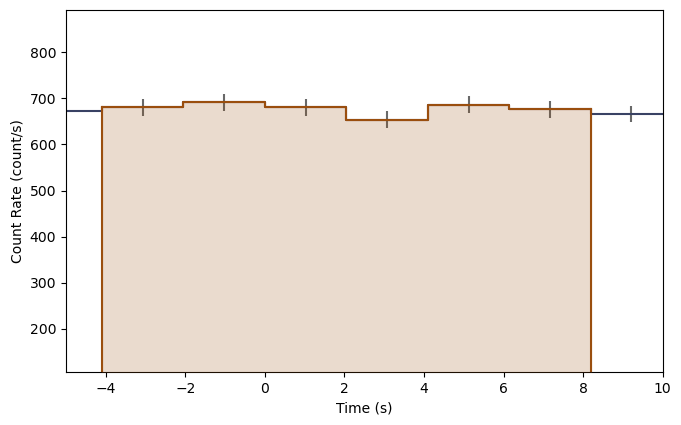

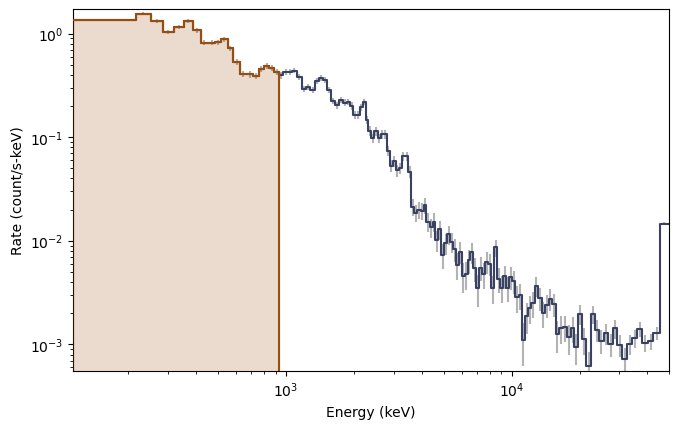

In [115]:
# get energies

# lcplot = Lightcurve(data=lc_data, background=lc_bkgd)

# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-5.0,10.0)
# lcplot.xlim = view_range

src_time = (-3,8)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

lcplot = Lightcurve(data=lc_data)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range

# why the resolution

# the observed count spectrum during the source selection
spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
# spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)

specplot = Spectrum(data=spec_data)
specplot.add_selection(spec_selection)




In [74]:
lc_data.counts.max()

2270.0

In [60]:
burstcat.columns

array(['name', 'ra', 'dec', 'trigger_time', 't90', 't90_error',
       't90_start', 'fluence', 'fluence_error', 'flux_1024',
       'flux_1024_error', 'flux_1024_time', 'flux_64', 'flux_64_error',
       'flnc_band_ampl', 'flnc_band_ampl_pos_err',
       'flnc_band_ampl_neg_err', 'flnc_band_epeak',
       'flnc_band_epeak_pos_err', 'flnc_band_epeak_neg_err',
       'flnc_band_alpha', 'flnc_band_alpha_pos_err',
       'flnc_band_alpha_neg_err', 'flnc_band_beta',
       'flnc_band_beta_pos_err', 'flnc_band_beta_neg_err',
       'flnc_spectrum_start', 'flnc_spectrum_stop',
       'pflx_best_fitting_model', 'pflx_best_model_redchisq',
       'flnc_best_fitting_model', 'flnc_best_model_redchisq',
       'actual_1024ms_interval', 'actual_256ms_interval',
       'actual_64ms_interval', 'back_interval_high_start',
       'back_interval_high_stop', 'back_interval_low_start',
       'back_interval_low_stop', 'bcat_detector_mask', 'bcatalog', 'bii',
       'duration_energy_high', 'duration_energy

In [64]:
burstcat.get_table(columns=('name','trigger_name', 't90','t90_start','scatalog'))

rec.array([('GRB120403857', 'bn120403857',  4.288, -3.968,      3),
           ('GRB120227725', 'bn120227725', 17.408,  0.256,      3),
           ('GRB230524357', 'bn230524357', 11.008, -5.632, -99999), ...,
           ('GRB130528695', 'bn130528695', 55.553,  0.576,      3),
           ('GRB090813174', 'bn090813174',  7.552,  0.384,      3),
           ('GRB110201399', 'bn110201399',  8.192, -1.792,      3)],
          dtype=[('name', '<U23'), ('trigger_name', '<U23'), ('t90', '<f8'), ('t90_start', '<f8'), ('scatalog', '<i8')])

In [37]:
#check if exists 
import os

i=0

if not os.path.isdir('./'+bursts.trigger_name[i]):
    path_tte = './'+bursts.trigger_name[0]
    trig_finder.get_tte(path_tte)
else:
    print('TTE Downloaded')

TTE Downloaded


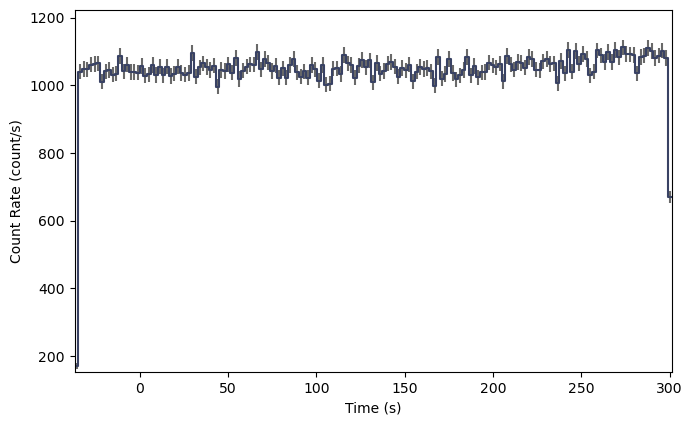

In [45]:
import gbm
from gbm import test_data_dir
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
import glob

%matplotlib inline
from gbm.plot import Lightcurve, Spectrum

files_tte = glob.glob(path_tte+'/*tte*')

# for i in range(len(files_tte)):
# open a TTE file
tte = TTE.open(files_tte[8])
# bin to 1.024 s resolution, reference time is trigger time
phaii = tte.to_phaii(bin_by_time, 1.024*2, time_ref=0.0)

erange = (8.0, 900.0)

lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)


In [59]:
lc_data.counts
lc_data.centroids


array([-35.84 , -33.792, -31.744, -29.696, -27.648, -25.6  , -23.552,
       -21.504, -19.456, -17.408, -15.36 , -13.312, -11.264,  -9.216,
        -7.168,  -5.12 ,  -3.072,  -1.024,   1.024,   3.072,   5.12 ,
         7.168,   9.216,  11.264,  13.312,  15.36 ,  17.408,  19.456,
        21.504,  23.552,  25.6  ,  27.648,  29.696,  31.744,  33.792,
        35.84 ,  37.888,  39.936,  41.984,  44.032,  46.08 ,  48.128,
        50.176,  52.224,  54.272,  56.32 ,  58.368,  60.416,  62.464,
        64.512,  66.56 ,  68.608,  70.656,  72.704,  74.752,  76.8  ,
        78.848,  80.896,  82.944,  84.992,  87.04 ,  89.088,  91.136,
        93.184,  95.232,  97.28 ,  99.328, 101.376, 103.424, 105.472,
       107.52 , 109.568, 111.616, 113.664, 115.712, 117.76 , 119.808,
       121.856, 123.904, 125.952, 128.   , 130.048, 132.096, 134.144,
       136.192, 138.24 , 140.288, 142.336, 144.384, 146.432, 148.48 ,
       150.528, 152.576, 154.624, 156.672, 158.72 , 160.768, 162.816,
       164.864, 166.

In [2]:
from gbm.finder import TriggerCatalog

trigcat = TriggerCatalog()
trigcat.num_rows
trigcat.columns
# error_radius is the statistical localization radius in degrees
trigcat.column_range('error_radius')
trigcat.get_table(columns=('trigger_name', 'trigger_time'))


Finished in 9 s


rec.array([('bn120403857', '2012-04-03 20:33:58.493'),
           ('bn140912846', '2014-09-12 20:18:03.669'),
           ('bn120227725', '2012-02-27 17:24:41.054'), ...,
           ('bn110201399', '2011-02-01 09:35:10.251'),
           ('bn150705660', '2015-07-05 15:50:18.845'),
           ('bn220403863', '2022-04-03 20:42:39.048')],
          dtype=[('trigger_name', '<U23'), ('trigger_time', '<U23')])

In [3]:
sliced_trigcat = trigcat.slice('error_radius', lo=1.1, hi=10.0)
sliced_trigcat.num_rows

2772

In [4]:
sliced_trigcat.get_table(columns=('trigger_name', 'trigger_time'))


rec.array([('bn120227725', '2012-02-27 17:24:41.054'),
           ('bn230524357', '2023-05-24 08:34:31.512'),
           ('bn141205018', '2014-12-05 00:25:29.813'), ...,
           ('bn091012783', '2009-10-12 18:47:02.770'),
           ('bn180304259', '2018-03-04 06:12:47.267'),
           ('bn220810258', '2022-08-10 06:12:01.186')],
          dtype=[('trigger_name', '<U23'), ('trigger_time', '<U23')])

In [5]:
sliced_trigcat2 = trigcat.slices([('error_radius', 1.1, 10.0), ('trigger_time', '2019-01-01 00:00:00', None)])
sliced_trigcat2.num_rows

856

In [6]:
sliced_trigcat2.get_table(columns=('trigger_name', 'trigger_time', 'error_radius'))


rec.array([('bn090704783', '2019-01-02 06:11:31.125',  6.35  ),
           ('bn140603476', '2019-01-17 08:50:43.596',  2.13  ),
           ('bn130104721', '2019-01-18 22:29:49.932',  2.44  ),
           ('bn150622879', '2019-01-19 05:59:03.575',  6.1833),
           ('bn091023021', '2019-01-29 12:55:42.675',  7.23  ),
           ('bn110331604', '2019-01-31 02:36:33.938',  4.66  ),
           ('bn160330827', '2019-01-31 23:08:35.673',  4.75  ),
           ('bn201118405', '2019-02-01 06:03:28.818',  2.69  ),
           ('bn170423872', '2019-02-02 05:36:55.718',  2.52  ),
           ('bn201218798', '2019-02-02 15:13:12.939',  5.72  ),
           ('bn181119649', '2019-02-03 23:24:11.710',  9.54  ),
           ('bn220308233', '2019-02-04 15:02:50.914',  5.29  ),
           ('bn220501478', '2019-02-05 22:31:15.658',  9.83  ),
           ('bn140807500', '2019-02-15 18:31:22.475',  2.53  ),
           ('bn120222021', '2019-02-17 04:31:26.137',  2.76  ),
           ('bn170618475', '2019-02-18 0

In [8]:
burstcat.columns

array(['name', 'ra', 'dec', 'trigger_time', 't90', 't90_error',
       't90_start', 'fluence', 'fluence_error', 'flux_1024',
       'flux_1024_error', 'flux_1024_time', 'flux_64', 'flux_64_error',
       'flnc_band_ampl', 'flnc_band_ampl_pos_err',
       'flnc_band_ampl_neg_err', 'flnc_band_epeak',
       'flnc_band_epeak_pos_err', 'flnc_band_epeak_neg_err',
       'flnc_band_alpha', 'flnc_band_alpha_pos_err',
       'flnc_band_alpha_neg_err', 'flnc_band_beta',
       'flnc_band_beta_pos_err', 'flnc_band_beta_neg_err',
       'flnc_spectrum_start', 'flnc_spectrum_stop',
       'pflx_best_fitting_model', 'pflx_best_model_redchisq',
       'flnc_best_fitting_model', 'flnc_best_model_redchisq',
       'actual_1024ms_interval', 'actual_256ms_interval',
       'actual_64ms_interval', 'back_interval_high_start',
       'back_interval_high_stop', 'back_interval_low_start',
       'back_interval_low_stop', 'bcat_detector_mask', 'bcatalog', 'bii',
       'duration_energy_high', 'duration_energy

In [7]:
bursts = burstcat.get_table(columns=('name','trigger_name', 't90','t90_error'))

In [29]:
# the datafinder class for triggers
from gbm.finder import TriggerFtp

# initialize the Trigger data finder with a trigger number
trig_finder = TriggerFtp('190114873')
trig_finder.num_files

# bursts.name[0]

ValueError: 190114873 is not a valid trigger number

/Users/tahumada/Research/GBM/gbm_data_tools-1.1.1/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


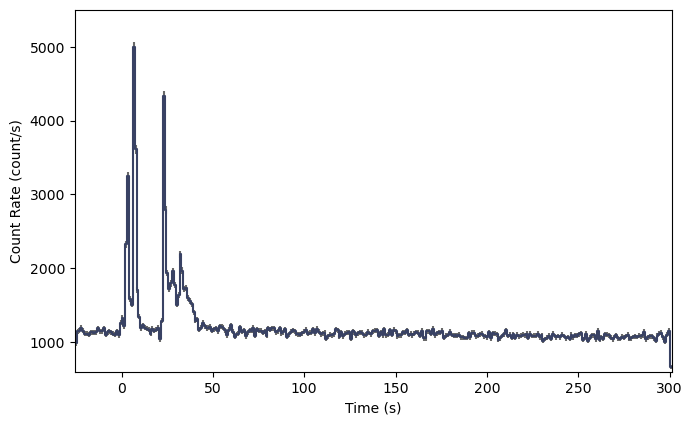

In [19]:
from gbm import test_data_dir
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time

# open a TTE file
tte = TTE.open(test_data_dir+'/glg_tte_n9_bn090131090_v00.fit')
# bin to 1.024 s resolution, reference time is trigger time
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)
%matplotlib inline
from gbm.plot import Lightcurve, Spectrum

erange = (8.0, 900.0)

lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)


In [26]:
burstcat

In [2]:
# the datafinder class for continuous data
from gbm.finder import ContinuousFtp

# initialize the continuous data finder with a time (Fermi MET, UTC, or GPS)
cont_finder = ContinuousFtp(utc='2020-08-16T00:00:00')
# cont_finder.num_files

In [8]:
# the datafinder class for triggers
from gbm.finder import TriggerFtp

# initialize the Trigger data finder with a trigger number
trig_finder = TriggerFtp('190114873')
trig_finder.num_files

Connection appears to have failed.  Attempting to reconnect...
Reconnected.


122

In [102]:
trig_finder.ls_tte()[0][8:10]

'b0'